In [2]:
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

In [3]:
worksheet = gc.open('xmm_with_redshift').sheet1

# get_all_values gives a list of rows.
rows = worksheet.get_all_values()

index = [i[0] for i in rows[1:]]
adjusted_rows = [i[1:] for i in rows[1:]]

import pandas as pd
df = pd.DataFrame.from_records(adjusted_rows, columns=rows[0][1:], index=index)

df.head()

,SC_RA,SC_DEC,SC_EP_8_FLUX,SC_EP_8_FLUX_ERR,objID,RAJ2000,DEJ2000,gmag,e_gmag,rmag,...,W2mag,W3mag,W4mag,e_W1mag,e_W2mag,e_W3mag,e_W4mag,nbref,main_type,zsp
207009901010024,0.006905748378,68.13455524,2.89E-14,8.30E-15,189760000053982249,0.00535066,68.13450866,,,,...,14.485,11.595,8.903,0.04,0.065,0.241,0.44,,,
201253101010057,0.007534431099,-25.28516856,1.79E-14,1.35E-14,77650000066568040,0.00666557,-25.28524502,21.3264,0.0372,20.9832,...,16.382,12.454,9.144,0.141,0.361,,,,,
206584004010022,0.00871585155,44.5149709,2.56E-14,1.06E-14,161410000079588615,0.00789686,44.51494177,19.6866,0.0137,19.4907,...,15.175,11.587,8.89,0.052,0.083,0.136,,,,
203025805010017,0.01007083288,-32.25863789,1.91E-14,3.96E-15,69290000106580013,0.01062854,-32.25865907,,,,...,15.038,12.265,8.723,0.064,0.101,0.385,,,,
201253101010009,0.0112696999,-25.19337615,7.40E-14,1.33E-14,77760000111487954,0.0111867,-25.19365618,21.6948,0.0807,21.372,...,,,,,,,,6,Seyfert_1,


In [4]:
import numpy as np
df = df.replace('',np.nan)

In [5]:
for i in range(len(df.columns)):
  try:
    df[df.columns[i]] = df[df.columns[i]].apply(pd.to_numeric)
  except:
    print(i)
    pass
df.dtypes

33


SC_RA               float64
SC_DEC              float64
SC_EP_8_FLUX        float64
SC_EP_8_FLUX_ERR    float64
objID               float64
RAJ2000             float64
DEJ2000             float64
gmag                float64
e_gmag              float64
rmag                float64
e_rmag              float64
imag                float64
e_imag              float64
zmag                float64
e_zmag              float64
ymag                float64
e_ymag              float64
parallax            float64
parallax_error      float64
pm                  float64
pmra                float64
pmra_error          float64
pmdec               float64
pmdec_error         float64
W1mag               float64
W2mag               float64
W3mag               float64
W4mag               float64
e_W1mag             float64
e_W2mag             float64
e_W3mag             float64
e_W4mag             float64
nbref               float64
main_type            object
zsp                 float64
dtype: object

In [6]:
def is_AGN(classification, ref):
  value = "Unknown"
  try:
    if classification in ["QSO", "Seyfert_1", "Seyfert_2", "BLLac", "Blazar", "RadioG", "AGN"] and ref>=3:
      return True
    elif pd.isna(classification):
      return value
    elif ref<3 or "Candidate" in classification:
      return value
    else:
      return False
  except Exception as e:
    print(e)
    print(classification, ref)
    input()

df["is_AGN"] = df.apply(lambda x: is_AGN(x.main_type, x.nbref), axis=1)
df.is_AGN.value_counts()

Unknown    186387
True        23068
False       11669
Name: is_AGN, dtype: int64

In [7]:
df = df[(abs(df["parallax"]/df["parallax_error"])<=3) | (df["parallax"].isnull())]
df.shape

(182923, 36)

In [8]:
df = df[(abs(df.pmra/df.pmra_error)<=3) | df.pmra.isnull()]
df.shape

(171728, 36)

In [9]:
df = df[(abs(df.pmdec/df.pmdec_error)<=3) | df.pmdec.isnull()]
df.shape

(167268, 36)

In [10]:
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [11]:
def model_stats(y_test, y_pred):
  print("Accuracy: ", metrics.accuracy_score(y_test, y_pred))
  print("Precision: ", metrics.precision_score(y_test, y_pred))
  print("Recall: ", metrics.recall_score(y_test, y_pred))

In [12]:
df["log_flux"] = np.log10(df["SC_EP_8_FLUX"])
input_labels = ['gmag', 'ymag','rmag', "zmag", 'imag', "W1mag", "W2mag", "W3mag", "W4mag", "log_flux", "is_AGN"]
known_df = df[df["is_AGN"] != "Unknown"]
input_df = known_df[input_labels].dropna()
y = input_df["is_AGN"].astype(int)
X = input_df.drop("is_AGN", axis=1)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [13]:
from sklearn.ensemble import RandomForestClassifier

Regression_model = RandomForestClassifier(n_estimators = 200, random_state = 0)
Regression_model.fit(X_train, y_train)

y_pred = Regression_model.predict(X_test)
model_stats(y_test, y_pred)

Accuracy:  0.935072142064373
Precision:  0.9551539491298527
Recall:  0.96614759647935


In [14]:
from sklearn.ensemble import HistGradientBoostingClassifier

known_df = df[df["is_AGN"] != "Unknown"]
known_df = known_df[input_labels]
y = known_df["is_AGN"].astype(int)
X = known_df.drop("is_AGN", axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

Hist_tree = HistGradientBoostingClassifier(early_stopping = True).fit(X_train, y_train)
y_pred2 = Hist_tree.predict(X_test)

model_stats(y_test, y_pred2)

Accuracy:  0.9316318926974665
Precision:  0.9471092077087795
Recall:  0.9735857362976007


In [15]:
df = pd.DataFrame.from_records(adjusted_rows, columns=rows[0][1:], index=index)
df = df.replace('',np.nan)
for i in range(len(df.columns)):
  try:
    df[df.columns[i]] = df[df.columns[i]].apply(pd.to_numeric)
  except:
    print(i)
    pass

33


In [16]:
def is_AGN(x):
  value = "Unknown"
  if x.main_type in ["QSO", "Seyfert_1", "Seyfert_2", "BLLac", "Blazar", "RadioG", "AGN"] and x.nbref>=3:
    return True
  elif x.parallax/x.parallax_error > 3 or x.pmra/x.pmra_error>3 or x.pmdec/x.pmdec_error>3:
    return False
  elif pd.isna(x.main_type):
    return value
  elif x.nbref<3 or "Candidate" in x.main_type:
    return value
  else:
    return False

df["is_AGN"] = df.apply(lambda x: is_AGN(x), axis=1)
df.is_AGN.value_counts()

Unknown    153056
False       45000
True        23068
Name: is_AGN, dtype: int64

In [17]:
def classifier(x):
  if x.parallax/x.parallax_error > 3 or x.pmra/x.pmra_error>3 or x.pmdec/x.pmdec_error>3:
    return 0
  elif x.parallax/x.parallax_error > 1 or x.pmra/x.pmra_error>1 or x.pmdec/x.pmdec_error>1:
    return 1
  else:
    return 2

df["classification"] = df.apply(lambda x: classifier(x), axis=1)
df.classification.value_counts()

2    158622
0     40847
1     21655
Name: classification, dtype: int64

In [18]:
df["log_flux"] = np.log10(df["SC_EP_8_FLUX"])
input_labels = ['gmag', 'ymag','rmag', "zmag", 'imag', "W1mag", "W2mag", "W3mag", "W4mag", "log_flux", "is_AGN", "classification"]
known_df = df[df["is_AGN"] != "Unknown"]
input_df = known_df[input_labels].dropna()
y = input_df["is_AGN"].astype(int)
X = input_df.drop("is_AGN", axis=1)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [19]:
Regression_model = RandomForestClassifier(n_estimators = 200, random_state = 0)
Regression_model.fit(X_train, y_train)

y_pred = Regression_model.predict(X_test)
model_stats(y_test, y_pred)

Accuracy:  0.9675454259006407
Precision:  0.9423841059602649
Recall:  0.9547131834954713


In [20]:
known_df = df[df["is_AGN"] != "Unknown"]
known_df = known_df[input_labels]
y = known_df["is_AGN"].astype(int)
X = known_df.drop("is_AGN", axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

Hist_tree = HistGradientBoostingClassifier(early_stopping = True).fit(X_train, y_train)
y_pred2 = Hist_tree.predict(X_test)

model_stats(y_test, y_pred2)

Accuracy:  0.9679741442632585
Precision:  0.9440734557595993
Recall:  0.9641943734015346


<Axes: xlabel='rate', ylabel='accuracy'>

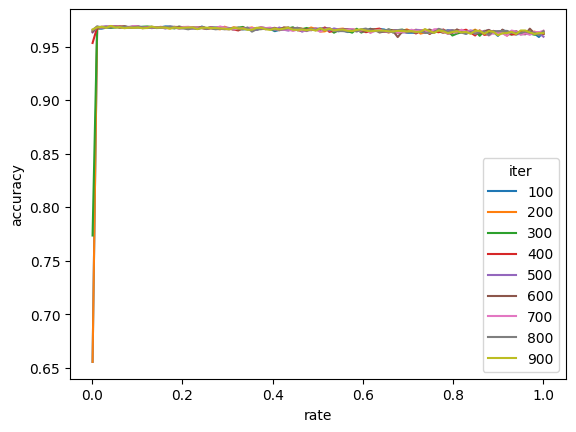

In [ ]:
metrics_dic = {"rate":[],"iter":[],"accuracy":[]}
for rate in np.linspace(0.001,1,100):
  for iter in range(100,1000,100):
    Hist_tree = HistGradientBoostingClassifier(early_stopping = True, learning_rate = rate, max_iter = iter).fit(X_train, y_train)
    y_pred = Hist_tree.predict(X_test)
    metrics_dic["rate"].append(rate)
    metrics_dic["iter"].append(iter)
    metrics_dic["accuracy"].append(metrics.accuracy_score(y_test, y_pred))

metrics_df=pd.DataFrame(metrics_dic)

import seaborn as sns

sns.lineplot(data = metrics_df, x="rate", y="accuracy", hue = metrics_df['iter'].astype(str))

In [ ]:
metrics_df.sort_values("accuracy").tail()

,rate,iter,accuracy
16,0.011091,800,0.968929
65,0.071636,300,0.969002
37,0.041364,200,0.969076
87,0.091818,700,0.969149
44,0.041364,900,0.969296


In [ ]:
from sklearn.model_selection import GridSearchCV
model = HistGradientBoostingClassifier()
space = dict()
space["learning_rate"] = np.linspace(0.001,1,100)
space["max_iter"] = range(100,1000,100)
space['early_stopping'] = [True]
space["max_leaf_nodes"] = range(1,50,10)


search = GridSearchCV(model, space, scoring='accuracy', n_jobs=-1)
result = search.fit(X, y)

print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
4500 fits failed out of a total of 22500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4500 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_hist_gradient_boosting/gradient_boosting.py", line 353, in fit
    self._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/l

Best Score: 0.9660785398673575
Best Hyperparameters: {'early_stopping': True, 'learning_rate': 0.011090909090909092, 'max_iter': 700, 'max_leaf_nodes': 41}


<Axes: xlabel='estimators', ylabel='accuracy'>

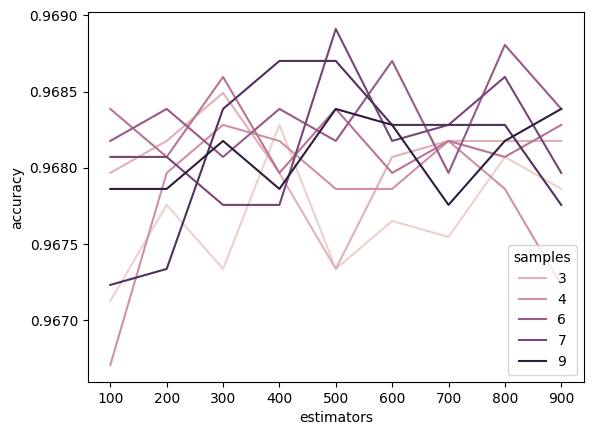

In [ ]:
known_df = df[df["is_AGN"] != "Unknown"]
input_df = known_df[input_labels].dropna()
y = input_df["is_AGN"].astype(int)
X = input_df.drop("is_AGN", axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

metrics_dic = {"samples":[],"estimators":[],"accuracy":[]}
for estimators in range(100,1000, 100):
  for samples in range(2,10):
    forest = RandomForestClassifier(n_estimators = estimators, min_samples_split = samples).fit(X_train, y_train)
    y_pred = forest.predict(X_test)
    metrics_dic["samples"].append(samples)
    metrics_dic["estimators"].append(estimators)
    metrics_dic["accuracy"].append(metrics.accuracy_score(y_test, y_pred))

metrics_df=pd.DataFrame(metrics_dic)

import seaborn as sns

sns.lineplot(data = metrics_df, x="estimators", y="accuracy", hue = "samples")

<Axes: xlabel='estimators', ylabel='accuracy'>

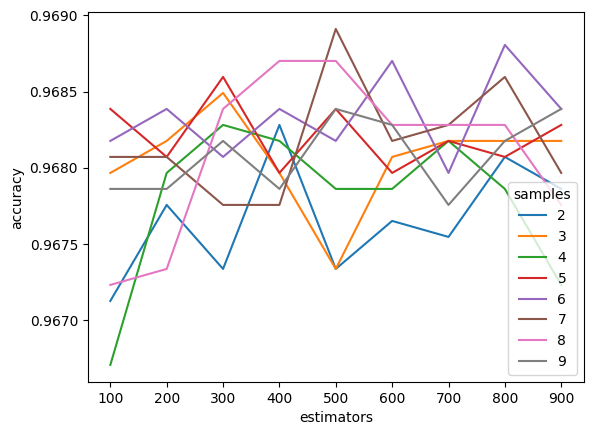

In [ ]:
sns.lineplot(data = metrics_df, x="estimators", y="accuracy", hue = metrics_df["samples"].astype(str))

In [ ]:
metrics_df.sort_values("accuracy").tail()

,samples,estimators,accuracy
38,8,500,0.968701
30,8,400,0.968701
44,6,600,0.968701
60,6,800,0.968806
37,7,500,0.968911


In [ ]:
known_df = df[df["is_AGN"] != "Unknown"]
input_df = known_df[input_labels].dropna()
y = input_df["is_AGN"].astype(int)
X = input_df.drop("is_AGN", axis=1)

model = RandomForestClassifier()
space = dict()
space["min_samples_split"] = range(2,15)
space["n_estimators"] = range(500,1200,100)

from sklearn.model_selection import GridSearchCV
search = GridSearchCV(model, space, scoring='accuracy', n_jobs=-1)
result = search.fit(X, y)

print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)